參考: https://reurl.cc/DZNNQR
Github: https://github.com/yacoubb/stock-trading-ml

# TBD

1. 整理 code
2. * 討論標準化的方法(min-max scalar, standard scalar)
     * 例如：一開始就正規化所有的資料(含 test)作法是否正確，因為 min-max scalar 隨股價上漲，導致正規化的標準會參考到 test 的資料
     * 目前增加 DCO 和 DHL 兩個 features，討論其影響
3. 測試紀錄不同的股票
4. 改進交易策略

* Introduction
  * LSTM 簡介
* method
  * ipynb 內容講解
* result
  * 準確度(MSE)與賺多少錢(交易策略)
* discussion
  * 列還可以改的參數 blablabla
  
## Todo:


* 台股/美股各選 3 隻，並且搭配不一樣的參數去跑（the technical indicators used, history_points hyperparameter, buy/sell algorithm/hyperparameters and model architecture ），統計出我們最好的 LSTM 的策略
* 加入 sharp ratio 去比較三種評分方式(sharp ratio/MSE/漲跌預測正確率)的優缺及適合的交易策略

In [1]:
# [不管美股/台股都要跑這裡] 設定變數，後面會用到（改 stock_id 即可） 

stock_id = 'MSFT' # 2330(台股) or APPL(美股)
start_date, end_date = '2001-12-01', '2021-12-28'
csvname = stock_id +'_daily.csv'
h5name = stock_id + '_daily.h5'

In [14]:
# 下載美股用此 function (參考網頁使用的方法)

from alpha_vantage.timeseries import TimeSeries
import json

def save_dataset(symbol):
    #credentials = json.load(open('creds.json', 'r'))
    #api_key = credentials['av_api_key']
    api_key = "TZ1RUCWBNBED2EWJ"

    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol, outputsize='full')
    
    data = data.reset_index()
    data = data.drop('date', axis=1)
    data = data.drop(0, axis=0)
    
    data.columns = ["Open", "High", "Low", "Close", "Volume"]
    data['DCO'] = data['Close'] - data['Open']
    data['DHL'] = data['High'] - data['Low']
    print(data.tail())

    data.to_csv(csvname, index=False)
    print(len(data.columns))
    return len(data.columns)

num_of_features = save_dataset(stock_id)

       Open   High    Low  Close      Volume   DCO   DHL
5572  91.81  92.87  90.50  91.56  35083700.0 -0.25  2.37
5573  92.31  92.75  90.31  91.75  27119700.0 -0.56  2.44
5574  92.94  93.50  91.50  92.00  22258500.0 -0.94  2.00
5575  92.75  94.50  91.94  92.56  23174500.0 -0.19  2.56
5576  93.25  94.19  92.12  92.37  26630600.0 -0.88  2.07
7


In [ ]:
# 下載台股用此 function

from FinMind.data import DataLoader

api = DataLoader()
df = api.taiwan_stock_daily(
    stock_id=stock_id,
    start_date=start_date,
    end_date=end_date
)

df = df.drop(columns=['date', 'stock_id', 'Trading_money', 'spread', 'Trading_turnover']) 
df = df.rename(columns={"open":"Open",
                        "max":"High",
                        "min":"Low",
                        "close": "Close",
                        "Trading_Volume": "Volume"})
df = df[["Open", "High", "Low", "Close", "Volume"]]
df['DCO'] = df['Close'] - df['Open']
df['DHL'] = df['High'] - df['Low']

# 設定參數，設定 model 時用
num_of_features = len(df.columns)


df.to_csv(csvname, index=False)

# 

In [15]:
# Preprocess API

import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50


def csv_to_dataset(csv_path):
    data = pd.read_csv(csv_path, index_col=False)
    #data = data.drop('date', axis=1)
    #data = data.drop(0, axis=0)

    # 1. X(normalised) - 把 ohlcv + DCO + DHL 資料正規化
    #                    用 {history_points = 50} 去生成 history_points parameter（用此去預測 the next open value）
    data = data.values
    data_normaliser = preprocessing.MinMaxScaler()
    data_normalised = data_normaliser.fit_transform(data)
    ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    print(data_normalised)

    # 2. y(normalised) - 收集正規化的 next day open values，並且展維(for keras)
    next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
    next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

    # 3. unscaled_y + 展維（for keras）
    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1)

    # 4. normaliser - ??
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(next_day_open_values) 

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    # 額外新增技術指標 [SMA（{history_points = 50}日平均 close price）, ]
    technical_indicators = []
    for his in ohlcv_histories_normalised:
        sma = np.mean(his[:, 3])
        macd = calc_ema(his, 12) - calc_ema(his, 26)
        technical_indicators.append(np.array([sma]))
        # 範例: technical_indicators.append(np.array([sma,macd,]))

    # 正規化
    technical_indicators = np.array(technical_indicators)
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    # Output:
    #   ohlcv_histories_normalised: 正規化的 X
    #   technical_indicators_normalised: 正規化的技術指數
    #   next_day_open_values_normalised: 正規化的 y
    #   next_day_open_values: 未正規化的 y
    #   y_normaliser: 未正規化的 y --> (y_normaliser) --> next_day_open_values_normalised
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]
    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

'''
# 沒用到
def multiple_csv_to_dataset(test_set_name):
    import os
    ohlcv_histories = 0
    technical_indicators = 0
    next_day_open_values = 0
    for csv_file_path in list(filter(lambda x: x.endswith('daily.csv'), os.listdir('./'))):
        if not csv_file_path == test_set_name:
            print(csv_file_path)
            if type(ohlcv_histories) == int:
                ohlcv_histories, technical_indicators, next_day_open_values, _, _ = csv_to_dataset(csv_file_path)
            else:
                a, b, c, _, _ = csv_to_dataset(csv_file_path)
                ohlcv_histories = np.concatenate((ohlcv_histories, a), 0)
                technical_indicators = np.concatenate((technical_indicators, b), 0)
                next_day_open_values = np.concatenate((next_day_open_values, c), 0)

    ohlcv_train = ohlcv_histories
    tech_ind_train = technical_indicators
    y_train = next_day_open_values

    ohlcv_test, tech_ind_test, y_test, unscaled_y_test, y_normaliser = csv_to_dataset(test_set_name)

    return ohlcv_train, tech_ind_train, y_train, ohlcv_test, tech_ind_test, y_test, unscaled_y_test, y_normaliser
'''

"\n# 沒用到\ndef multiple_csv_to_dataset(test_set_name):\n    import os\n    ohlcv_histories = 0\n    technical_indicators = 0\n    next_day_open_values = 0\n    for csv_file_path in list(filter(lambda x: x.endswith('daily.csv'), os.listdir('./'))):\n        if not csv_file_path == test_set_name:\n            print(csv_file_path)\n            if type(ohlcv_histories) == int:\n                ohlcv_histories, technical_indicators, next_day_open_values, _, _ = csv_to_dataset(csv_file_path)\n            else:\n                a, b, c, _, _ = csv_to_dataset(csv_file_path)\n                ohlcv_histories = np.concatenate((ohlcv_histories, a), 0)\n                technical_indicators = np.concatenate((technical_indicators, b), 0)\n                next_day_open_values = np.concatenate((next_day_open_values, c), 0)\n\n    ohlcv_train = ohlcv_histories\n    tech_ind_train = technical_indicators\n    y_train = next_day_open_values\n\n    ohlcv_test, tech_ind_test, y_test, unscaled_y_test, y_normal

In [16]:
# Preprocess 

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser  = csv_to_dataset(csvname)

[[0.99553761 0.98245772 0.99425656 ... 0.0167646  0.43218884 0.15961995]
 [0.97219355 0.97847628 0.97931751 ... 0.02408783 0.81373391 0.32874109]
 [0.96396697 0.96024547 0.97106895 ... 0.02352532 0.59699571 0.16769596]
 ...
 [0.23599053 0.23313875 0.23410625 ... 0.0280377  0.47339056 0.0888361 ]
 [0.23541376 0.23613232 0.23545046 ... 0.02960297 0.5055794  0.11543943]
 [0.23693158 0.23520431 0.23600037 ... 0.0355088  0.47596567 0.09216152]]


In [17]:
# split train and test
#   ohlcv_train: 0.9; y_train: 0.9
#   ohlcv_test:  0.1; y_test: 0.1
#   unscaled_y_test: 0.1                

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

![](https://i.imgur.com/XKEjgLw.png)

* The input layer has shape (history_points, OHLCV), since each input data point is an array shaped like [50 × 5]
* The model has 50 LSTM cells in the first layer,
* A dropout layer to prevent overfitting
* Some dense layers to bring all of the LSTM data together.
* An important feature of this network is the linear output activation, allowing the model to tune its penultimate weights accurately

In [18]:
# demo 時要講解每個 layer (todo)

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
#from tensorflow import set_random_seed
#set_random_seed(4)
tf.random.set_seed(4)

# define two sets of inputs
# {history_points = 50} 的 ohlcv 餵到 lstm_input
lstm_input = Input(shape=(history_points, num_of_features), name='lstm_input') 
# 技術指標餵到 tech_input
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')
 
# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input) # 不知道這裡的 50 是 history_points or 固定值
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)
 
# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=adam, loss='mse')

In [19]:
# training

model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate([ohlcv_test, tech_ind_test], y_test)
print(evaluation)

Epoch 1/50
140/140 [==============================] - 15s 20ms/step - loss: 0.0261 - val_loss: 9.5275e-05
Epoch 2/50
140/140 [==============================] - 2s 16ms/step - loss: 5.4891e-04 - val_loss: 9.0604e-05
Epoch 3/50
140/140 [==============================] - 2s 15ms/step - loss: 4.6922e-04 - val_loss: 7.0751e-05
Epoch 4/50
140/140 [==============================] - 2s 16ms/step - loss: 4.2214e-04 - val_loss: 6.3622e-05
Epoch 5/50
140/140 [==============================] - 2s 16ms/step - loss: 3.3262e-04 - val_loss: 6.0340e-05
Epoch 6/50
140/140 [==============================] - 2s 16ms/step - loss: 3.0908e-04 - val_loss: 6.3747e-05
Epoch 7/50
140/140 [==============================] - 2s 15ms/step - loss: 2.9273e-04 - val_loss: 7.4415e-05
Epoch 8/50
140/140 [==============================] - 2s 16ms/step - loss: 2.8658e-04 - val_loss: 1.0126e-04
Epoch 9/50
140/140 [==============================] - 2s 18ms/step - loss: 2.7234e-04 - val_loss: 5.3983e-05
Epoch 10/50
140/140 [=

In [20]:
# evaluation

# 用剛剛 train 好的 model 去預測 test 的資料
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
# 把正規劃的還原成原本的 next day open price
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)


#y_predicted = model.predict([ohlcv_histories, technical_indicators])
#y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape

# 算 mse(實際-預測)
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))

# TBD2 - 要討論如何訂標準去評估不同股票的預測準確度誰比較高
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

49.9376639843193


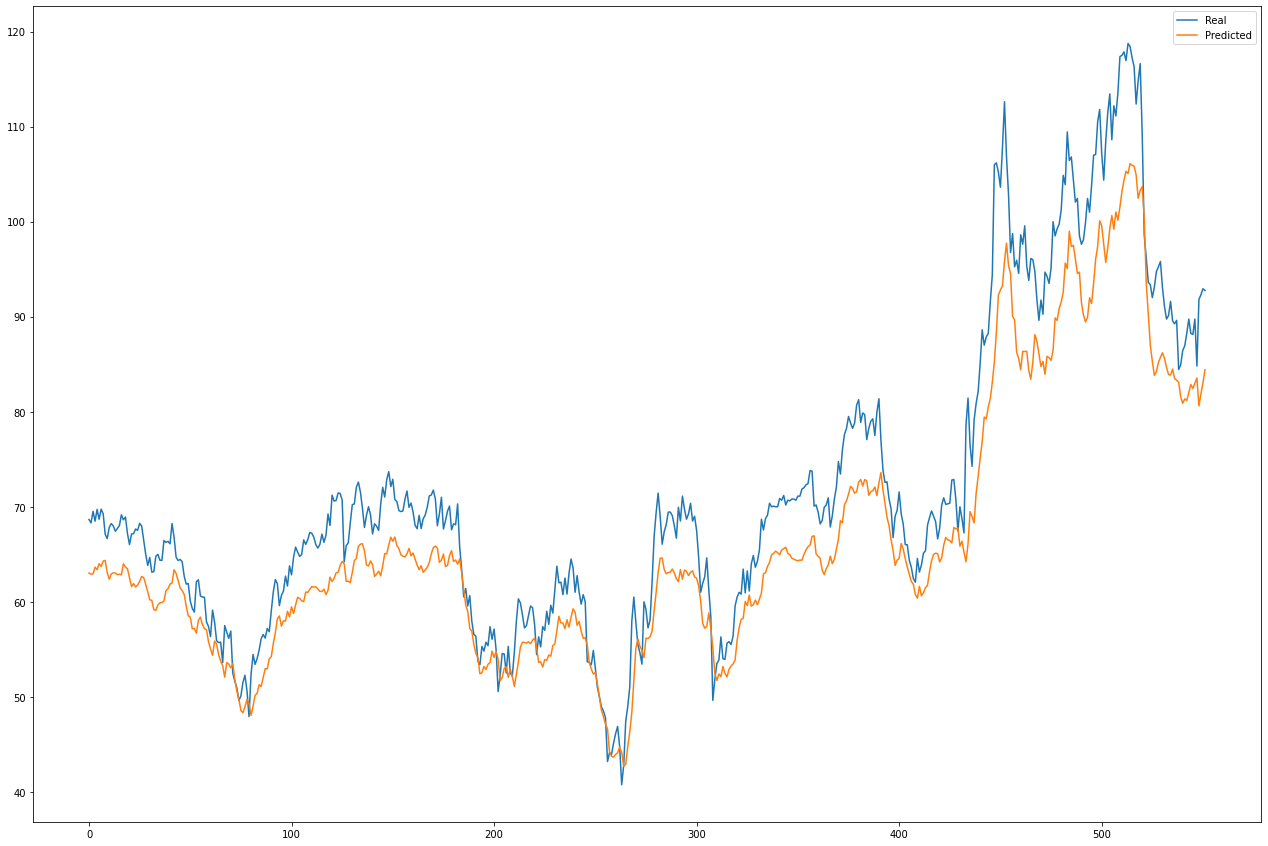

In [21]:
# 就畫圖

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(h5name)

# 實際設計 Algo 來看可以靠預測來賺多少 

[[0.99553761 0.98245772 0.99425656 ... 0.0167646  0.43218884 0.15961995]
 [0.97219355 0.97847628 0.97931751 ... 0.02408783 0.81373391 0.32874109]
 [0.96396697 0.96024547 0.97106895 ... 0.02352532 0.59699571 0.16769596]
 ...
 [0.23599053 0.23313875 0.23410625 ... 0.0280377  0.47339056 0.0888361 ]
 [0.23541376 0.23613232 0.23545046 ... 0.02960297 0.5055794  0.11543943]
 [0.23693158 0.23520431 0.23600037 ... 0.0355088  0.47596567 0.09216152]]
4973
552
buys: 280
sells: 271
89.6477214498206 13.20562868071125
265 282


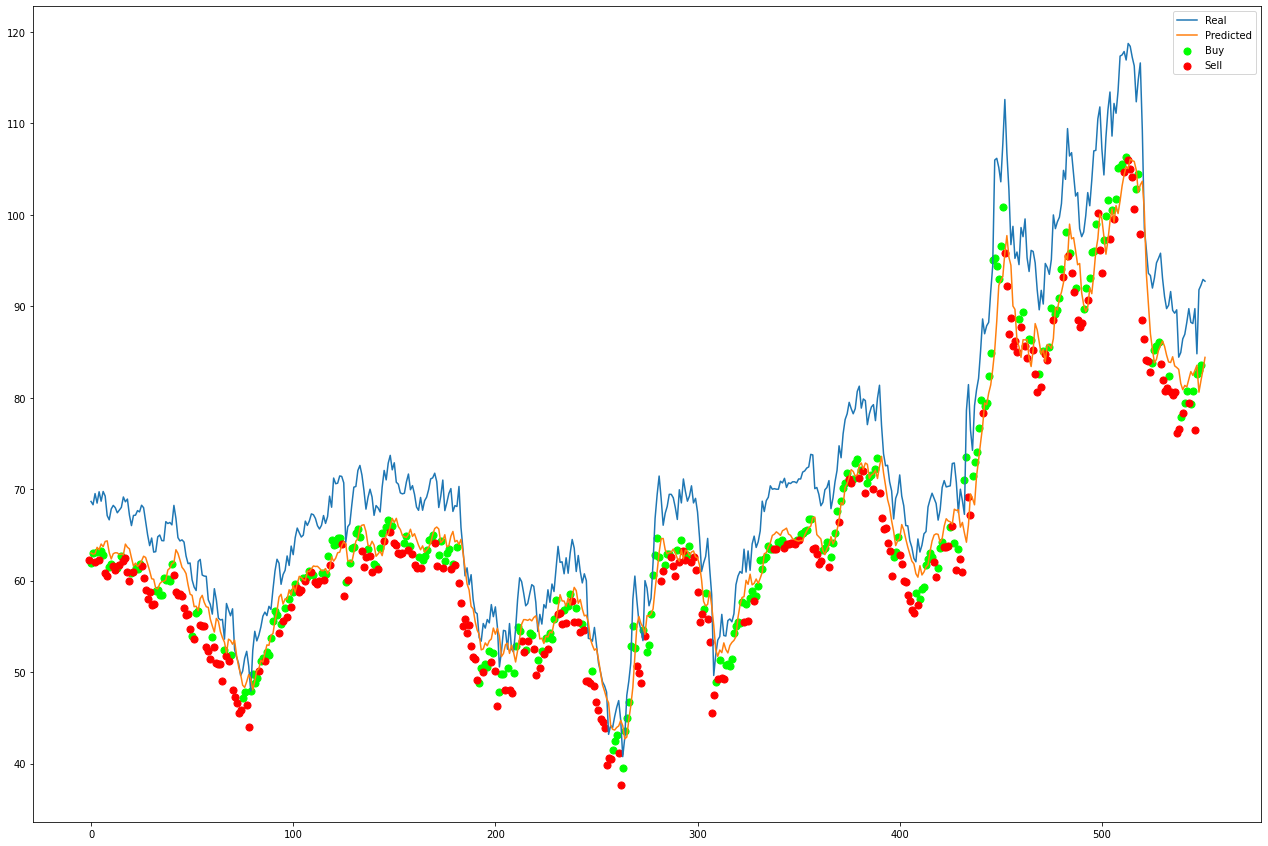

In [22]:
# 交易策略 1 (已知 bug: 圖中的點點會跑掉)

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset(csvname)

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)
print(n)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

buys = []
sells = []
thresh = 0.0

start = 0
end = -1

x = -1

# go through 20 年找買所有的買賣點（明日開盤價夠高就買，夠低就賣）
for i, (ohlcv, ind) in enumerate(zip(ohlcv_test[start: end], tech_ind_test[start: end])):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_normaliser.inverse_transform(normalised_price_today)
    predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict([ohlcv.reshape(1, 50, -1), ind.reshape(1, -1)])))
    if i > 0:
        delta = (predicted_price_tomorrow - predicted_price_today) / predicted_price_today
        # print(predicted_price_tomorrow, predicted_price_today, delta)
        if delta > thresh:
            buys.append((x, price_today[0][0])) #（第幾筆買點, 買價）
        elif delta < -thresh:
            sells.append((x, price_today[0][0])) #（第幾筆賣點, 賣價）
        x += 1
    predicted_price_today = predicted_price_tomorrow

print(len(ohlcv_test[start: end]))
print(f"buys: {len(buys)}")
print(f"sells: {len(sells)}")

# 拿今天有的五十筆資料去預測明天的開盤價，如果明天開盤價夠高就買十塊，夠低就全賣
# TBD
def compute_earnings(buys, sells):
    purchase_amt = 10
    stock = 0
    balance = 0
    while len(buys) > 0 and len(sells) > 0:
        if buys[0][0] < sells[0][0]: # 判斷現在是買點還賣點，若為買點
            # time to buy $10 worth of stock
            balance -= buys[0][1]
            stock += 1
            buys.pop(0)
        else: # 若為賣點
            # time to sell all of our stock
            balance += sells[0][1]
            stock -= 1 
            sells.pop(0)
    print(balance)

def compute_earnings2(buys, sells):
    purchase_amt = 10
    stock = 0
    balance = 0
    clean = 0
    correct, incorrect = 0, 0
    yesterday_price = None
    # init first trade
    if len(buys) > 0 and len(sells) > 0:
        if buys[0][0] < sells[0][0]:
            is_yesterday_buy = True
            balance -= buys[0][1]
            yesterday_price = buys[0][1]
            buys.pop(0)
        else:
            is_yesterday_buy = False
            balance += sells[0][1]
            yesterday_price = sells[0][1]
            sells.pop(0)
            
    while len(buys) > 0 and len(sells) > 0:
        if buys[0][0] < sells[0][0]: # 判斷目前是買點還賣點，若為買點
            today_price = buys[0][1];
            if is_yesterday_buy: # 先結算昨天：昨天買，今天就賣
                balance += today_price
                if today_price - yesterday_price > 0:
                    clean += (today_price - yesterday_price)
                    correct += 1
                    #print(f'+ [{buys[0][0]}] Sell, actual: {today_price - yesterday_price}({today_price} - {yesterday_price})')
                else:
                    clean += (today_price - yesterday_price)
                    incorrect += 1
                    #print(f'- [{buys[0][0]}] Sell, actual: {today_price - yesterday_price}({today_price} - {yesterday_price})')
            else: # 昨天賣今天買回來
                balance -= today_price
                if today_price - yesterday_price < 0:
                    clean -= (today_price - yesterday_price)
                    correct += 1
                    #print(f'+ [{buys[0][0]}] BuyBack, actual: {today_price - yesterday_price}({today_price} - {yesterday_price})')
                else:
                    clean -= (today_price - yesterday_price)
                    incorrect += 1
                    #print(f'- [{buys[0][0]}] BuyBack, actual: {today_price - yesterday_price}({today_price} - {yesterday_price})')
            # 結算完前一天的，因為今天是買點所以來買
            balance -= today_price
            yesterday_price = today_price
            is_yesterday_buy = True
            buys.pop(0)
        else: # 若為賣點
            today_price = sells[0][1];
            if is_yesterday_buy: # 先結算昨天：昨天買，今天就賣
                balance += today_price
                if today_price - yesterday_price > 0:
                    clean += (today_price - yesterday_price)
                    correct += 1
                    #print(f'+ [{buys[0][0]}] Sell, actual: {today_price - yesterday_price}({today_price} - {yesterday_price})')
                else:
                    clean += (today_price - yesterday_price)
                    incorrect += 1
                    #print(f'- [{buys[0][0]}] Sell, actual: {today_price - yesterday_price}({today_price} - {yesterday_price})')
            else: # 反之
                balance -= today_price
                if today_price - yesterday_price < 0:
                    clean -= (today_price - yesterday_price)
                    correct += 1
                    #print(f'+ [{buys[0][0]}] BuyBack, actual: {today_price - yesterday_price}({today_price} - {yesterday_price})')
                else:
                    clean -= (today_price - yesterday_price)
                    incorrect += 1
                    #print(f'- [{buys[0][0]}] BuyBack, actual: {today_price - yesterday_price}({today_price} - {yesterday_price})')
            # 結算完前一天的，因為今天是賣點所以來賣
            balance += today_price
            yesterday_price = today_price
            is_yesterday_buy = False
            sells.pop(0)
        # 最後一張待補
    print(balance, clean)
    print(correct, incorrect)

# we create new lists so we dont modify the original
compute_earnings2([b for b in buys], [s for s in sells])

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buys) > 0:
    plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00', s=50)
if len(sells) > 0:
    plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', s=50)

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])

plt.show()

[[0.99553761 0.98245772 0.99425656 ... 0.0167646  0.43218884 0.15961995]
 [0.97219355 0.97847628 0.97931751 ... 0.02408783 0.81373391 0.32874109]
 [0.96396697 0.96024547 0.97106895 ... 0.02352532 0.59699571 0.16769596]
 ...
 [0.23599053 0.23313875 0.23410625 ... 0.0280377  0.47339056 0.0888361 ]
 [0.23541376 0.23613232 0.23545046 ... 0.02960297 0.5055794  0.11543943]
 [0.23693158 0.23520431 0.23600037 ... 0.0355088  0.47596567 0.09216152]]
buys: 280
sells: 271
earnings: $14.886025135086065


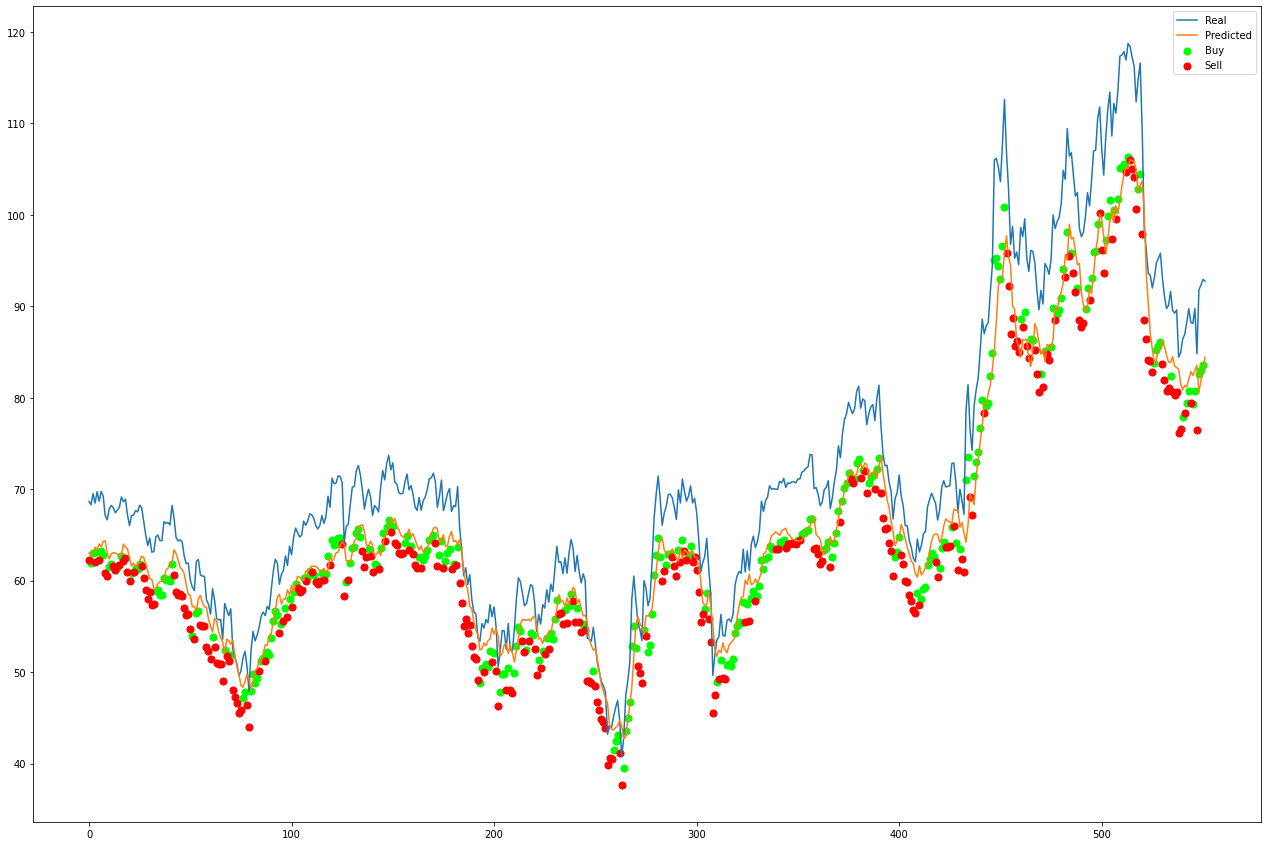

In [23]:
# 交易策略 2

import numpy as np
from keras.models import load_model
#from util import history_points #csv_to_dataset
from operator import xor

#model = load_model(h5name)

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset(csvname)

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

y_test_predicted = model.predict(([ohlcv_test, tech_ind_test]))
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

buys = []
sells = []
thresh = 0.1*0

start = 0
end = -1

x = -1

    


for i, (ohlcv, ind) in enumerate(zip(ohlcv_test[start: end], tech_ind_test[start: end])):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_normaliser.inverse_transform(normalised_price_today)

    ggg = model.predict([ohlcv.reshape(1,50,-1), ind.reshape(1,-1)])
    gggggg = y_normaliser.inverse_transform(ggg)
    predicted_price_tomorrow = np.squeeze(gggggg)
    if i > 0:
        delta = predicted_price_tomorrow - predicted_price_today
        diff_price = price_today[0][0] - price_yesterday[0][0]
        if delta > thresh:
            buys.append((x, price_today, diff_price))
        elif delta < -thresh:
            sells.append((x, price_today, diff_price))
    predicted_price_today = predicted_price_tomorrow
    price_yesterday = price_today
    x += 1
print(f"buys: {len(buys)}")
print(f"sells: {len(sells)}")

from operator import xor
def compute_earnings(buys_, sells_):
    purchase_amt = 10
    stock = 0
    balance = 0
    did_buy = (buys_[0][0] < sells_[0][0])
    trade =  buys_ if did_buy else sells_
    trade.pop(0)
    while len(buys_) > 0 and len(sells_) > 0:
        trade =  buys_ if did_buy else sells_
        dff_price = trade[0][2]
        if xor(did_buy, dff_price >=0):
            balance -= dff_price
        else:
            balance += dff_price
        did_buy = (buys_[0][0] < sells_[0][0])
        trade.pop(0)
        
    print(f"earnings: ${balance}")


# we create new lists so we dont modify the original
compute_earnings([b for b in buys], [s for s in sells])

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buys) > 0:
    plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00', s=50)
if len(sells) > 0:
    plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', s=50)

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])

plt.show()
